In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
import constants as c

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/mode_choice')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# load input
cfs_summary_data = read_csv(c.input_dir + c.cfs_summary_file, sep = ',')
modeled_data = read_csv(c.output_dir + c.modeled_file, sep = ',')
faf_data = read_csv(c.input_dir + c.faf_version_4_file, sep = ',')
#  cfs_distribution = read_csv(c.input_dir + c.cfs_dir + c.cfs_distribution_file, sep = ',')

modeled_data = modeled_data.loc[modeled_data['mode_choice'] != 'Other']

In [3]:
# generate modeled national shipment count fraction
modeled_count_by_sctg = modeled_data.groupby(['mode_choice', 'SCTG_Name'])[['count']].sum()
modeled_count_by_sctg = modeled_count_by_sctg.reset_index()
modeled_count_total = modeled_data.groupby(['SCTG_Name'])[['count']].sum()
modeled_count_total = modeled_count_total.reset_index()
modeled_count_by_sctg = pd.merge(modeled_count_by_sctg, modeled_count_total, 
                                 on = 'SCTG_Name', how = 'left')
modeled_count_by_sctg.loc[:, 'Count_fraction'] = modeled_count_by_sctg.loc[:, 'count_x'] / modeled_count_by_sctg.loc[:, 'count_y']
modeled_count_by_sctg = modeled_count_by_sctg.loc[:, ['SCTG_Name', 'mode_choice','Count_fraction']]

modeled_count_all_sctg = modeled_data.groupby(['mode_choice'])[['count']].sum()
modeled_count_all_sctg = modeled_count_all_sctg.reset_index()
modeled_count_all_sctg.loc[:, 'SCTG_Name'] = 'all'
modeled_count_all_sctg.loc[:, 'Count_fraction'] = modeled_count_all_sctg.loc[:, 'count'] / modeled_count_all_sctg.loc[:, 'count'].sum()
modeled_count_all_sctg = modeled_count_all_sctg.loc[:, ['SCTG_Name', 'mode_choice', 'Count_fraction']]
modeled_count = pd.concat([modeled_count_by_sctg, modeled_count_all_sctg])
modeled_count.loc[:, 'Source'] = 'Modeled'
modeled_count.loc[:, 'Area'] = 'Austin'
modeled_count.head(5)                                                    

,SCTG_Name,mode_choice,Count_fraction,Source,Area
0,bulk,Air,0.000002,Modeled,Austin
1,fuel_fert,Air,0.000015,Modeled,Austin
2,interm_food,Air,0.000010,Modeled,Austin
3,mfr_goods,Air,0.000333,Modeled,Austin
4,bulk,For-hire Truck,0.289219,Modeled,Austin


In [4]:
# compare % of shipment count with CFS
mode_matching = {'Air': 'air', 'For-hire Truck': 'for-hire truck',
                 'Parcel': 'parcel',  'Private Truck': 'private truck',
                 "Rail/IMX": 'rail/IMX'}

# combined_modeled_count = pd.concat([modeled_count, bay_area_modeled_count])
# modeled_count.loc[:, 'mode_choice'] = modeled_count.loc[:, 'mode_choice'].map(mode_matching)
cfs_count = cfs_summary_data.loc[:, ['SCTG_Name', 'mode_choice', 'Count_fraction', 'Source', 'Area']]
cfs_count = cfs_count.loc[cfs_count['Area'] == 'Austin']
print(cfs_summary_data.SCTG_Name.unique())
compare_shipment_count = pd.concat([cfs_count, modeled_count])
compare_shipment_count.head(5)

['bulk' 'fuel_fert' 'interm_food' 'mfr_goods' 'other' 'all']


,SCTG_Name,mode_choice,Count_fraction,Source,Area
60,bulk,Air,0.005848,CFS2012,Austin
61,bulk,For-hire Truck,0.463706,CFS2012,Austin
62,bulk,Parcel,0.094474,CFS2012,Austin
63,bulk,Private Truck,0.419794,CFS2012,Austin
64,bulk,Rail/IMX,0.016179,CFS2012,Austin


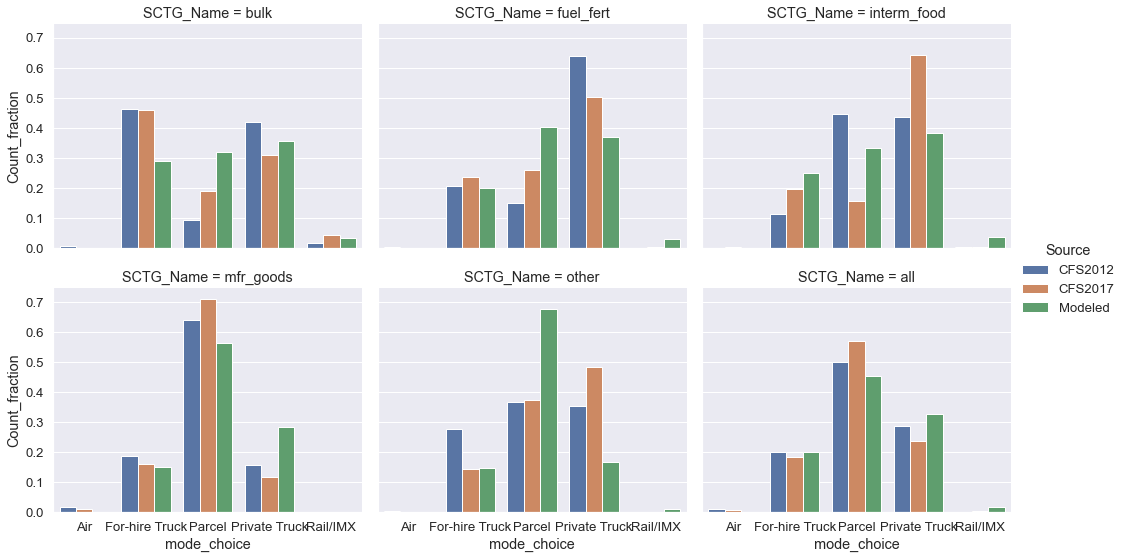

In [5]:
# plot shipment fraction comparison

# compare_shipment_count_to_plot = compare_shipment_count.loc[compare_shipment_count['Area'] == a]
sns.catplot(x = "mode_choice", y = 'Count_fraction', hue = 'Source',
                col = "SCTG_Name", col_wrap = 3,
                data = compare_shipment_count, height = 4, aspect=1.2, kind = "bar")
#     plt.title('mode split comparison (' + a + ')')
# plt.xticks(rotation = 60)
plt.savefig('plot/mode_split_by_sctg_austin.png', dpi = 200)
plt.show()